In [437]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pprint
import onnxmltools
from onnxconverter_common.data_types import FloatTensorType
import onnx
import onnxruntime as rt
import numpy as np

In [438]:
data.shape

(10000, 13)

In [439]:
data = np.genfromtxt('data/PHTSV_Table_HMAX_Adjusted.csv', delimiter=',')
data = data[1:, :]

# 2 D array containing Pressure and Enthalpy data
P_H = data[:, 0:3]

# Scale the pressure to bar and scale the enthalpy to kJ/mol
P_H[:, 0] = P_H[:, 0] / 1e5
P_H[:, 1] = P_H[:, 1] / 1000

# Vector containing Temperatures
T = data[:, 3]

X_train, X_test, y_train, y_test = train_test_split(
    P_H, T, test_size=0.2, random_state=42)

In [440]:
# df = pd.read_csv(r"C:\Users\yufengq\Desktop\RA\polynomial3.csv")
# df.head()

# X = df["theta"]
# y = df["z"]

# X = X.reset_index(drop = True)
# y = y.reset_index(drop = True)

# X = X.to_numpy().reshape(-1, 1)
# y = y.to_numpy().reshape(-1, 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Train the model

In [441]:
train_data_linear = lgb.Dataset(X_train, label=y_train,
                        params={
                            'linear_tree': True
                        })

train_data_normal = lgb.Dataset(X_train, label=y_train)

In [442]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 5,
    "num_leaves": 20,
    "learning_rate": 1,
    "verbosity": -1, 
    'num_iterations': 4
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [443]:
y_pred_linear = model_linear.predict(X_test, num_iteration=model_linear.best_iteration)
y_pred_normal = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)

In [444]:
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 4.013
Normal trees error: 5.127


# PLot the graph

In [445]:
# y_linear = model_linear.predict(X, num_iteration=model_linear.best_iteration)
# y_normal = model_normal.predict(X, num_iteration=model_linear.best_iteration)

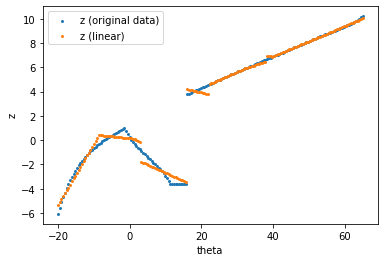

In [446]:
# plotting results
plt.scatter(X, y, label = 'z (original data)', marker = '.', linewidths=0.001)
plt.scatter(X, y_linear, label = 'z (linear)', marker = '.', linewidths=0.001)
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

# Save the model

In [447]:
model_linear.save_model('linear.txt')

In [448]:
# Load your LightGBM model

# lgb_model = lgb.Booster(model_file=input_lgb_model)

# Convert the LightGBM model into ONNX
# The initial_types argument is a python list.
# Each element is a tuple of a variable name and a type defined in onnxconverter_common/data_types.py
onnx_model = onnxmltools.convert_lightgbm(model_linear, initial_types=[('theta', FloatTensorType((None, X.shape[1])))])

# Save as protobuf

# onnxmltools.utils.save_model(onnx_model, output_onnx_model)

The maximum opset needed by this model is only 8.


In [449]:
converted_model = onnx.load(r"C:\Users\yufengq\Desktop\RA\model.onnx")

In [450]:
converted_model

ir_version: 3
producer_name: "OnnxMLTools"
producer_version: "1.13.0"
domain: "onnxconverter-common"
model_version: 0
doc_string: ""
graph {
  node {
    input: "theta"
    output: "variable"
    name: "LgbmRegressor"
    op_type: "TreeEnsembleRegressor"
    attribute {
      name: "n_targets"
      i: 1
      type: INT
    }
    attribute {
      name: "nodes_falsenodeids"
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 0
      ints: 6
      ints: 8
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 2
      ints: 4
      ints: 6
      ints: 0
      ints: 0
      ints: 0
      ints: 8
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "nodes_featureids"
      ints: 0
      ints: 0
      ints: 0
      i

In [451]:
onnx.checker.check_model(converted_model)

In [452]:
sess = rt.InferenceSession(r"C:\Users\yufengq\Desktop\RA\model.onnx")
result = sess.run(None, {'theta': X.astype(np.float32)})
np.array(result).shape

(1, 180, 1)

In [453]:
txt_model = lgb.Booster(model_file=r'C:\Users\yufengq\Desktop\RA\OMLT_ML\linear.txt')

In [454]:
txt_model.num_feature()

3

# Plot the tree

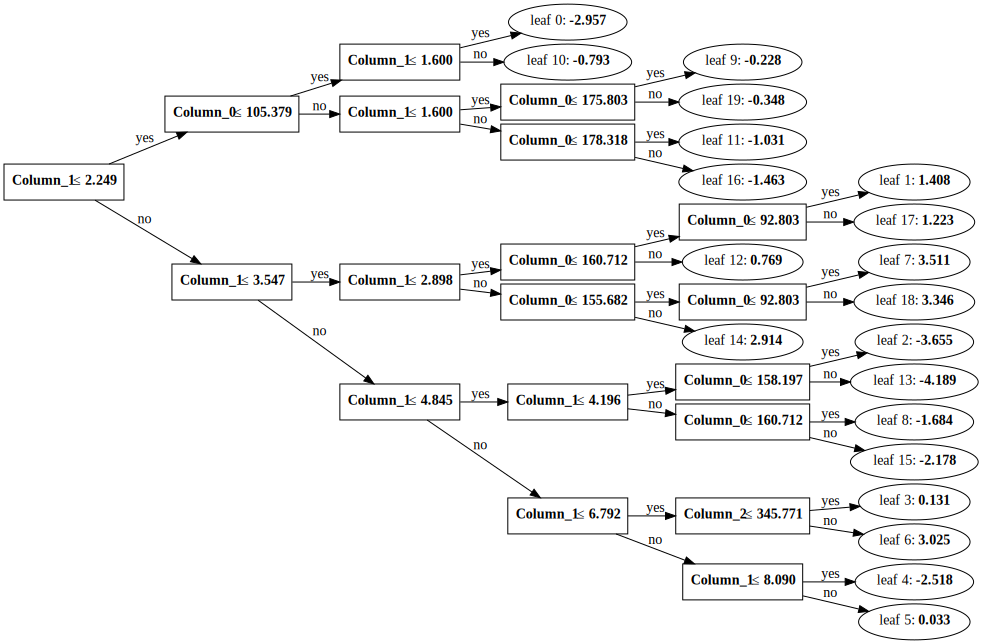

In [455]:
p = lgb.create_tree_digraph(model_linear, 3)
p

# Parse the tree

In [456]:
# change the model to json format
whole_model = model_linear.dump_model()
node  = whole_model['tree_info'][-1]["tree_structure"]

In [457]:
txt_model.dump_model()==whole_model

True

In [458]:
txt_model.params

{}

In [459]:
txt_model.num_feature()

3

In [460]:
tree = {}

tree['parameters'] = model_linear.params

for i in range(whole_model['tree_info'][-1]['tree_index']+1):

    node  = whole_model['tree_info'][i]["tree_structure"]

    queue = [node]
    splits = {}

    # the very first node
    splits["split"+str(queue[0]["split_index"])] = {'th': queue[0]["threshold"],
                                    'col': queue[0]["split_feature"] }

    # flow though the tree
    while queue:
        
        # left child
        if "left_child" in queue[0].keys():
            queue.append(queue[0]["left_child"])
            # child is a split
            if "split_index" in queue[0]["left_child"].keys():
                splits["split"+str(queue[0]["left_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'left',
                                                            'th': queue[0]["left_child"]["threshold"], 
                                                            'col': queue[0]["left_child"]["split_feature"]}
            # child is a leaf
            else:
                splits["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'left', 
                                                            'intercept': queue[0]["left_child"]["leaf_const"], 
                                                            'slope': queue[0]["left_child"]["leaf_coeff"]}
                
        # right child
        if "right_child" in queue[0].keys():
            queue.append(queue[0]["right_child"])      
            # child is a split
            if "split_index" in queue[0]["right_child"].keys():
                splits["split"+str(queue[0]["right_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'right',
                                                            'th': queue[0]["right_child"]["threshold"], 
                                                            'col': queue[0]["right_child"]["split_feature"]}
            # child is a leaf
            else:
                splits["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                            'direction': 'right',
                                                            'intercept': queue[0]["right_child"]["leaf_const"], 
                                                            'slope': queue[0]["right_child"]["leaf_coeff"]}
        # delet the first node
        queue.pop(0)

        tree['tree'+str(i)] = splits

In [461]:
tree

{'parameters': {'objective': 'regression',
  'metric': 'rmse',
  'max_depth': 5,
  'num_leaves': 20,
  'learning_rate': 1,
  'verbosity': -1,
  'num_iterations': 4,
  'early_stopping_round': None,
  'linear_tree': True},
 'tree0': {'split0': {'th': 30.803600215000003, 'col': 1},
  'split1': {'parent': 'split0',
   'direction': 'left',
   'th': 13.930620880000001,
   'col': 1},
  'split2': {'parent': 'split0',
   'direction': 'right',
   'th': 47.027618805,
   'col': 1},
  'split4': {'parent': 'split1',
   'direction': 'left',
   'th': 6.792052701,
   'col': 1},
  'split3': {'parent': 'split1',
   'direction': 'right',
   'th': 21.718149805000007,
   'col': 1},
  'split6': {'parent': 'split2',
   'direction': 'left',
   'th': 39.240089880000006,
   'col': 1},
  'split5': {'parent': 'split2',
   'direction': 'right',
   'th': 55.46410847500001,
   'col': 1},
  'split12': {'parent': 'split4',
   'direction': 'left',
   'th': 3.5472489825000006,
   'col': 1},
  'split10': {'parent': 'split

In [462]:
queue = [node]
splits = {}

# the very first node
splits["split"+str(queue[0]["split_index"])] = {'th': queue[0]["threshold"],
                                 'col': queue[0]["split_feature"] }

# flow though the tree
while queue:

    # left child
    if "left_child" in queue[0].keys():
        queue.append(queue[0]["left_child"])
        # child is a split
        if "split_index" in queue[0]["left_child"].keys():
            splits["split"+str(queue[0]["left_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'direction': 'left',
                                                           'th': queue[0]["left_child"]["threshold"], 
                                                           'col': queue[0]["left_child"]["split_feature"]}
        # child is a leaf
        else:
            splits["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'direction': 'left', 
                                                          'intercept': queue[0]["left_child"]["leaf_const"], 
                                                          'slope': queue[0]["left_child"]["leaf_coeff"]}
            
    # right child
    if "right_child" in queue[0].keys():
        queue.append(queue[0]["right_child"])      
        # child is a split
        if "split_index" in queue[0]["right_child"].keys():
            splits["split"+str(queue[0]["right_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'direction': 'right',
                                                           'th': queue[0]["right_child"]["threshold"], 
                                                           'col': queue[0]["right_child"]["split_feature"]}
        # child is a leaf
        else:
            splits["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'direction': 'right',
                                                          'intercept': queue[0]["right_child"]["leaf_const"], 
                                                          'slope': queue[0]["right_child"]["leaf_coeff"]}
    # delet the first node
    queue.pop(0)

In [463]:
splits

{'split0': {'th': 2.2493274955000007, 'col': 1},
 'split8': {'parent': 'split0',
  'direction': 'left',
  'th': 105.37878785000002,
  'col': 0},
 'split1': {'parent': 'split0',
  'direction': 'right',
  'th': 3.5472489825000006,
  'col': 1},
 'split9': {'parent': 'split8',
  'direction': 'left',
  'th': 1.600366752,
  'col': 1},
 'split10': {'parent': 'split8',
  'direction': 'right',
  'th': 1.600366752,
  'col': 1},
 'split6': {'parent': 'split1',
  'direction': 'left',
  'th': 2.8982882390000007,
  'col': 1},
 'split2': {'parent': 'split1',
  'direction': 'right',
  'th': 4.845170470000001,
  'col': 1},
 'leaf0': {'parent': 'split9',
  'direction': 'left',
  'intercept': 2.672795444726944,
  'slope': [-0.004834498987291436, -4.219900533556938]},
 'leaf10': {'parent': 'split9',
  'direction': 'right',
  'intercept': -0.06872076587751508,
  'slope': [-0.0018694211471065245, -0.32216420536860824]},
 'split18': {'parent': 'split10',
  'direction': 'left',
  'th': 175.80303030000002,
  '

In [464]:
# splits['leaf0'].keys()

In [465]:
# splits['split1'].keys()

coefficient and conatant could be a list to contain multivariables

In [466]:
# tree

In [467]:
for i in splits:
    print(i)
    break

split0


In [468]:
for i in splits:
    # print(i)
    if 'parent' in splits[i].keys():
        splits[splits[i]['parent']]['children'] = []

for i in splits:
    # print(i)
    if 'parent' in splits[i].keys():
        if splits[i]['direction'] == 'left':     
            splits[splits[i]['parent']]['children'].insert(0,i)
        if splits[i]['direction'] == 'right':     
            splits[splits[i]['parent']]['children'].insert(11,i)

In [469]:
leaves = {}
for i in splits.keys():
    if i[0] == 'l':
        leaves[i] = splits[i]
leaves

{'leaf0': {'parent': 'split9',
  'direction': 'left',
  'intercept': 2.672795444726944,
  'slope': [-0.004834498987291436, -4.219900533556938]},
 'leaf10': {'parent': 'split9',
  'direction': 'right',
  'intercept': -0.06872076587751508,
  'slope': [-0.0018694211471065245, -0.32216420536860824]},
 'leaf9': {'parent': 'split18',
  'direction': 'left',
  'intercept': -0.006900192005559802,
  'slope': [-0.0017375104002977301, 0.019493896747007966]},
 'leaf19': {'parent': 'split18',
  'direction': 'right',
  'intercept': 2.075688675045967,
  'slope': [-0.0017525915472392795, -1.6106849908828735]},
 'leaf11': {'parent': 'split15',
  'direction': 'left',
  'intercept': -0.6462503615766764,
  'slope': [-0.005964225089310882, 0.2412172332406044]},
 'leaf16': {'parent': 'split15',
  'direction': 'right',
  'intercept': 0.11322520487010479,
  'slope': [-0.005976035163543447, -0.15225440356880426]},
 'leaf12': {'parent': 'split11',
  'direction': 'right',
  'intercept': 0.3510746145620942,
  'slo

In [470]:
for leaf in leaves:
    del splits[leaf]

In [471]:
def find_all_children_splits(split, splits_dict):
    """
    This helper function finds all multigeneration children splits for an 
    argument split.

    Arguments:
        split --The split for which you are trying to find children splits
        splits_dict -- A dictionary of all the splits in the tree
    
    Returns:
        A list containing the Node IDs of all children splits
    """
    all_splits = []

    # Check if the immediate left child of the argument split is also a split.
    # If so append to the list then use recursion to generate the remainder
    left_child = splits_dict[split]['children'][0]
    if left_child in splits_dict:
        all_splits.append(left_child)
        all_splits.extend(find_all_children_splits(left_child, splits_dict))

    # Same as above but with right child
    right_child = splits_dict[split]['children'][1]
    if right_child in splits_dict:
        all_splits.append(right_child)
        all_splits.extend(find_all_children_splits(right_child, splits_dict))

    return all_splits

In [472]:
def find_all_children_leaves(split, splits_dict, leaves_dict):
    """
    This helper function finds all multigeneration children leaves for an 
    argument split.

    Arguments:
        split -- The split for which you are trying to find children leaves
        splits_dict -- A dictionary of all the split info in the tree
        leaves_dict -- A dictionary of all the leaf info in the tree

    Returns:
        A list containing all the Node IDs of all children leaves
    """
    all_leaves = []

    # Find all the splits that are children of the relevant split
    all_splits = find_all_children_splits(split, splits_dict)

    # Ensure the current split is included
    if split not in all_splits:
        all_splits.append(split)

    # For each leaf, check if the parents appear in the list of children
    # splits (all_splits). If so, it must be a leaf of the argument split
    for leaf in leaves_dict:
        if leaves_dict[leaf]['parent'] in all_splits:
            all_leaves.append(leaf)

    return all_leaves

In [473]:
splits

{'split0': {'th': 2.2493274955000007,
  'col': 1,
  'children': ['split8', 'split1']},
 'split8': {'parent': 'split0',
  'direction': 'left',
  'th': 105.37878785000002,
  'col': 0,
  'children': ['split9', 'split10']},
 'split1': {'parent': 'split0',
  'direction': 'right',
  'th': 3.5472489825000006,
  'col': 1,
  'children': ['split6', 'split2']},
 'split9': {'parent': 'split8',
  'direction': 'left',
  'th': 1.600366752,
  'col': 1,
  'children': ['leaf0', 'leaf10']},
 'split10': {'parent': 'split8',
  'direction': 'right',
  'th': 1.600366752,
  'col': 1,
  'children': ['split18', 'split15']},
 'split6': {'parent': 'split1',
  'direction': 'left',
  'th': 2.8982882390000007,
  'col': 1,
  'children': ['split11', 'split13']},
 'split2': {'parent': 'split1',
  'direction': 'right',
  'th': 4.845170470000001,
  'col': 1,
  'children': ['split7', 'split3']},
 'split18': {'parent': 'split10',
  'direction': 'left',
  'th': 175.80303030000002,
  'col': 0,
  'children': ['leaf9', 'leaf19

In [474]:
for split in splits:
    # print("split:" + str(split))
    left_child = splits[split]['children'][0]
    right_child = splits[split]['children'][1]
    
    if left_child in splits:
        # means left_child is split
        splits[split]['left_leaves'] = find_all_children_leaves(
            left_child, splits, leaves
            )
    else:
        # means left_child is leaf
        splits[split]['left_leaves'] = [left_child]
        # print("left_child" + str(left_child))
    
    if right_child in splits:
        splits[split]['right_leaves'] = find_all_children_leaves(
            right_child, splits, leaves
            )
    else:
        splits[split]['right_leaves'] = [right_child]
        # print("right_child" + str(right_child))

In [475]:
splitting_thresholds = {}
for split in splits:
    var = splits[split]['col']
    splitting_thresholds[var] = {}
for split in splits:
    var = splits[split]['col']
    splitting_thresholds[var][split] = splits[split]['th']

In [476]:
for var in splitting_thresholds:
    splitting_thresholds[var] = dict(sorted(splitting_thresholds[var].items(), key=lambda x: x[1]))

In [477]:
for split in splits:
    var = splits[split]['col']
    splits[split]['y_index'] = []
    splits[split]['y_index'].append(var)
    splits[split]['y_index'].append(
        list(splitting_thresholds[var]).index(split)
    )

In [478]:
print(txt_model)

In [479]:
n_inputs = txt_model.num_feature()

In [480]:
n_inputs

3

In [481]:
L = np.array(list(leaves.keys()))
features = np.arange(0,n_inputs)

In [482]:
for leaf in leaves:
    leaves[leaf]['bounds'] = {}
for th in features:
    print(th)
    for leaf in leaves:
        leaves[leaf]['bounds'][th] = [None, None]

0
1
2


In [483]:
print(leaves)

{'leaf0': {'parent': 'split9', 'direction': 'left', 'intercept': 2.672795444726944, 'slope': [-0.004834498987291436, -4.219900533556938], 'bounds': {0: [None, None], 1: [None, None], 2: [None, None]}}, 'leaf10': {'parent': 'split9', 'direction': 'right', 'intercept': -0.06872076587751508, 'slope': [-0.0018694211471065245, -0.32216420536860824], 'bounds': {0: [None, None], 1: [None, None], 2: [None, None]}}, 'leaf9': {'parent': 'split18', 'direction': 'left', 'intercept': -0.006900192005559802, 'slope': [-0.0017375104002977301, 0.019493896747007966], 'bounds': {0: [None, None], 1: [None, None], 2: [None, None]}}, 'leaf19': {'parent': 'split18', 'direction': 'right', 'intercept': 2.075688675045967, 'slope': [-0.0017525915472392795, -1.6106849908828735], 'bounds': {0: [None, None], 1: [None, None], 2: [None, None]}}, 'leaf11': {'parent': 'split15', 'direction': 'left', 'intercept': -0.6462503615766764, 'slope': [-0.005964225089310882, 0.2412172332406044], 'bounds': {0: [None, None], 1: [N

In [484]:
for split in splits:
    var = splits[split]['col']
    print(var)
    for leaf in splits[split]['left_leaves']:
        print(leaves[leaf]['bounds'])
    #     leaves[leaf]['bounds'][var][1] = splits[split]['th']

    # for leaf in splits[split]['right_leaves']:
    #     leaves[leaf]['bounds'][var][0] = splits[split]['th']

1
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
0
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
1
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
1
{0: [None, None], 1: [None, None], 2: [None, None]}
1
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}
1
{0: [None, None], 1: [None, None], 2: [None, None]}
{0: [None, None], 1: [None, None], 2: [None, None]}


In [485]:
def reassign_none_bounds(leaves, input_bounds):
    """
    This helper function reassigns bounds that are None to the bounds
    input by the user

    Arguments:
        leaves -- The dictionary of leaf information. Attribute of the 
            LinearTreeModel object
        input_bounds -- The nested dictionary

    Returns:
        The modified leaves dict without any bounds that are listed as None
    """
    L = np.array(list(leaves.keys()))
    features = np.arange(0, len(leaves[L[0]]['slope']))

    for l in L:
        for f in features:
            if leaves[l]['bounds'][f][0] == None:
                leaves[l]['bounds'][f][0] = input_bounds[f][0]
            if leaves[l]['bounds'][f][1] == None:
                leaves[l]['bounds'][f][1] = input_bounds[f][1]

    return leaves

In [486]:
def build_output_bounds(leaves, input_bounds):
    """
    This function develops bounds of the output variable based on the values
    of the input_bounds and the signs of the slope

    Arguments:
        leaves -- Dict of leaf information
        input_bounds -- Dict of input bounds

    Returns:
        List that contains the conservative lower and upper bounds of the 
        output variable
    """
    L = np.array(list(leaves.keys()))
    features = np.arange(0, len(leaves[L[0]]['slope']))

    # Initialize bounds and variables
    bounds = [0, 0]
    upper_bound = 0
    lower_bound = 0
    for l in leaves:
        slopes = leaves[l]['slope']
        intercept = leaves[l]['intercept']
        for k in features:
            if slopes[k] <= 0:
                upper_bound += slopes[k] * input_bounds[k][0] + intercept
                lower_bound += slopes[k] * input_bounds[k][1] + intercept
            else:
                upper_bound += slopes[k] * input_bounds[k][1] + intercept
                lower_bound += slopes[k] * input_bounds[k][0] + intercept
            if upper_bound >= bounds[1]:
                bounds[1] = upper_bound
            if lower_bound <= bounds[0]:
                bounds[0] = lower_bound
        upper_bound = 0
        lower_bound = 0

    return bounds


In [487]:
import pprint 
pp= pprint.PrettyPrinter(indent=4)

In [488]:
pp.pprint(splits)

{   'split0': {   'children': ['split8', 'split1'],
                  'col': 1,
                  'left_leaves': [   'leaf0',
                                     'leaf10',
                                     'leaf9',
                                     'leaf19',
                                     'leaf11',
                                     'leaf16'],
                  'right_leaves': [   'leaf12',
                                      'leaf14',
                                      'leaf1',
                                      'leaf17',
                                      'leaf7',
                                      'leaf18',
                                      'leaf2',
                                      'leaf13',
                                      'leaf8',
                                      'leaf15',
                                      'leaf3',
                                      'leaf6',
                                      'leaf4',
                      

In [489]:
pp.pprint(leaves)

{   'leaf0': {   'bounds': {0: [None, None], 1: [None, None], 2: [None, None]},
                 'direction': 'left',
                 'intercept': 2.672795444726944,
                 'parent': 'split9',
                 'slope': [-0.004834498987291436, -4.219900533556938]},
    'leaf1': {   'bounds': {0: [None, None], 1: [None, None], 2: [None, None]},
                 'direction': 'left',
                 'intercept': 0.7997110709547997,
                 'parent': 'split16',
                 'slope': [-0.0034898333412249627, 0.29802306555211544]},
    'leaf10': {   'bounds': {0: [None, None], 1: [None, None], 2: [None, None]},
                  'direction': 'right',
                  'intercept': -0.06872076587751508,
                  'parent': 'split9',
                  'slope': [-0.0018694211471065245, -0.32216420536860824]},
    'leaf11': {   'bounds': {0: [None, None], 1: [None, None], 2: [None, None]},
                  'direction': 'left',
                  'intercept': -0.64

In [490]:
pp.pprint(splitting_thresholds)

{   0: {   'split11': 160.71212125000002,
           'split12': 158.19696970000004,
           'split13': 155.68181815000003,
           'split14': 160.71212125000002,
           'split15': 178.31818185000003,
           'split16': 92.80303030500002,
           'split17': 92.80303030500002,
           'split18': 175.80303030000002,
           'split8': 105.37878785000002},
    1: {   'split0': 2.2493274955000007,
           'split1': 3.5472489825000006,
           'split10': 1.600366752,
           'split2': 4.845170470000001,
           'split3': 6.792052701,
           'split4': 8.089974188000001,
           'split6': 2.8982882390000007,
           'split7': 4.196209726000001,
           'split9': 1.600366752},
    2: {'split5': 345.7709903500001}}


In [491]:
# change the tree to desighed format


In [492]:
#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
import omlt

In [493]:
#create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize = 0)
model1.y = pyo.Var(initialize = 0)
model1.obj = pyo.Objective(expr=(model1.y))

#create an OmltBlock
model1.lt = OmltBlock()

In [494]:
leaves = reassign_none_bounds(leaves, input_bounds)
output_bounds = build_output_bounds(leaves, input_bounds)

block.outputs.setub(output_bounds[1])
block.outputs.setlb(output_bounds[0])
block.scaled_outputs.setub(output_bounds[1])
block.scaled_outputs.setlb(output_bounds[0])


def disjuncts_rule(d, l):

    def lb_Rule(d, f):
        return input_vars[f] >= leaves[l]['bounds'][f][0]
    d.lb_constraint = pe.Constraint(features, rule=lb_Rule)

    def ub_Rule(d, f):
        return input_vars[f] <= leaves[l]['bounds'][f][1]
    d.ub_constraint = pe.Constraint(features, rule=ub_Rule)

    slope = leaves[l]['slope']
    intercept = leaves[l]['intercept']
    d.linear_exp = pe.Constraint(
        expr=sum(slope[k]*input_vars[k] for k in features) 
        + intercept == output_vars[0]
        )
    
block.disjunct = Disjunct(L, rule=disjuncts_rule)

block.final_disjunction = Disjunction(
    expr=[block.disjunct[l] for l in L]
    )

transformation_string = 'gdp.' + transformation

pe.TransformationFactory(transformation_string).apply_to(block)

NameError: name 'input_bounds' is not defined